In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
%matplotlib inline

In [83]:
def maxnormed_bar(u,normed=True,**kwargs):
    vs, bs = np.histogram(u, bins=kwargs.get('bins',10))
    if normed:
        vs = vs / vs.max()
    kwargs.pop('bins')
    
    plt.bar(bs[:-1], vs, align='edge', width=bs[1]-bs[0], **kwargs)

def maxnormed_step(u,normed=True,**kwargs):
    vs, bs = np.histogram(u, bins=kwargs.get('bins',10))
    if normed:
        vs = vs / vs.max()
    kwargs.pop('bins')
    
    plt.step(bs[:-1], vs, where='post', **kwargs)

## Gradients 

In [179]:
T = 1024
N = 1024
L = 10

In [180]:
# vanilla
x = torch.randn(T,N,requires_grad=True).cuda() / np.sqrt(2)
x.retain_grad()
xs_vn, ys_vn, zs_vn = [x], [], []

for l in range(L):
    # forward
    W = torch.randn(N,N).cuda() / np.sqrt(N/2)
    y = x.mm(W)
    z = y
    x = z.relu()
    
    # retain grads
    y.retain_grad()
    x.retain_grad()
    z.retain_grad()
    
    # retain reference
    ys_vn.append(y)
    zs_vn.append(z)
    xs_vn.append(x)
    
    
# backward
# e = (torch.randn_like(x) * x).sum()
e = (torch.randn_like(x[:1]) * x).sum()
e.backward()

In [181]:
# batchnorm 
x = torch.randn(T,N,requires_grad=True).cuda() / np.sqrt(2)
x.retain_grad()
xs_bn, ys_bn, zs_bn = [x], [], []

for l in range(L):
    # forward
    W = torch.randn(N,N).cuda() / np.sqrt(N/2)
    y = x.mm(W)
    z = (y - y.mean(dim=0,keepdim=True) ) / y.std(dim=0,keepdim=True)
    x = z.relu()
    
    # retain grads
    y.retain_grad()
    x.retain_grad()
    z.retain_grad()
    
    # retain reference
    ys_bn.append(y)
    zs_bn.append(z)
    xs_bn.append(x)
    
    
# backward
# e = (torch.randn_like(x) * x).sum()
e = (torch.randn_like(x[:1]) * x).sum()
e.backward()

In [204]:
# batchnorm 
x = torch.randn(T,N,requires_grad=True).cuda() / np.sqrt(2)
x.retain_grad()
xs_fn, ys_fn, zs_fn = [x], [], []

for l in range(L):
    # forward
    W = torch.randn(N,N).cuda() / np.sqrt(N/2)
    y = x.mm(W)
    z = (y - y.mean(dim=0,keepdim=True).detach() ) / y.std(dim=0,keepdim=True).detach()
    x = z.relu()
    
    # retain grads
    y.retain_grad()
    x.retain_grad()
    z.retain_grad()
    
    # retain reference
    ys_fn.append(y)
    zs_fn.append(z)
    xs_fn.append(x)
    
    
# backward
# e = (torch.randn_like(x) * x).sum()
e = (torch.randn_like(x[:1]) * x).sum()
e.backward()

## Grad Norms 

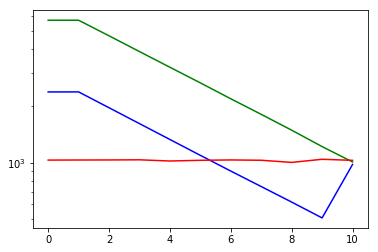

In [205]:
gxs_vn = [x.grad.norm().item() for x in xs_vn]
gxs_bn = [x.grad.norm().item() for x in xs_bn]
gxs_fn = [x.grad.norm().item() for x in xs_fn]

plt.plot(gxs_bn, color='blue', label='Batch Norm')
plt.plot(gxs_fn, color='green', label='Forward Norm')
plt.plot(gxs_vn, color='red', label='Vanilla')

plt.yscale('log')

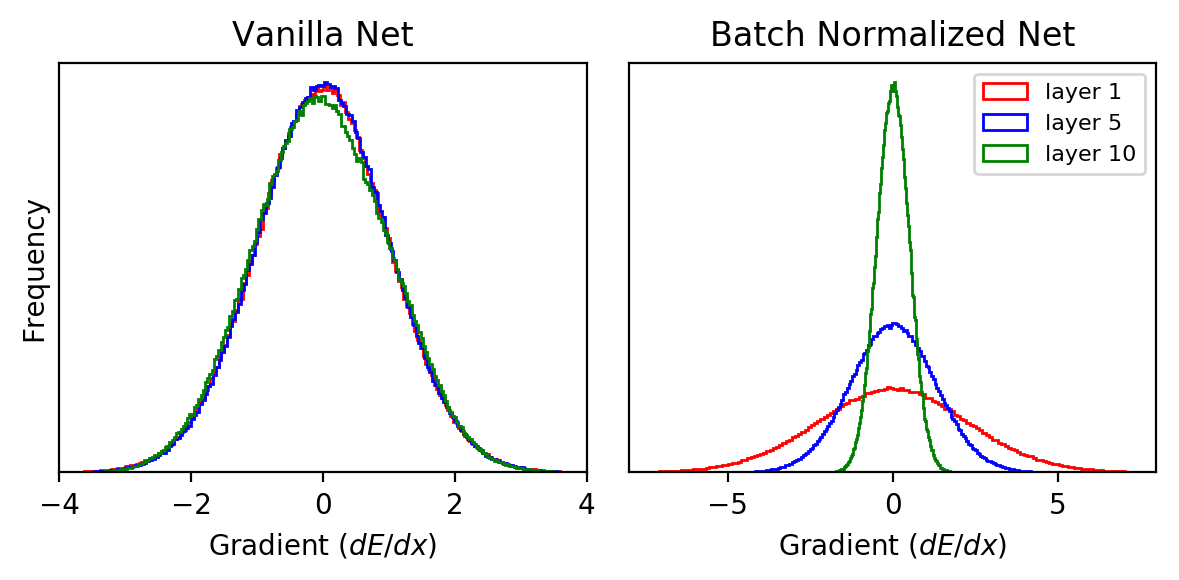

In [197]:
bins = 250
title_fontsize=12
axlabel_fontsize=10
legend_fontsize=8

plt.figure(figsize=(6,3), dpi=200)
plt.subplot(121)
plt.hist(xs_vn[0].grad.cpu().flatten(), label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(xs_vn[4].grad.cpu().flatten(), label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(xs_vn[9].grad.cpu().flatten(), label='layer 10', color='green', histtype='step', bins=bins, normed=True)

plt.xlim(-4.0,+4.0)

plt.xlabel(r'Gradient ($dE/dx$)', fontsize=axlabel_fontsize)
plt.ylabel('Frequency', fontsize=axlabel_fontsize)
plt.yticks([])
plt.title('Vanilla Net', fontsize=title_fontsize)

plt.subplot(122)
plt.hist(xs_bn[0].grad.cpu().flatten(), label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(xs_bn[4].grad.cpu().flatten(), label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(xs_bn[9].grad.cpu().flatten(), label='layer 10', color='green', histtype='step', bins=bins, normed=True)

# plt.xlim(-400,+400)
plt.xlim(-20, +20)
plt.xlim(-8, +8)

plt.legend(fontsize=legend_fontsize)
plt.yticks([])
plt.xlabel(r'Gradient ($dE/dx$)', fontsize=axlabel_fontsize)
plt.title('Batch Normalized Net', fontsize=title_fontsize)

plt.tight_layout()
# plt.savefig('../assets/bn_gradient_simulation.png')
plt.show()

In [211]:
xs_fn[9].grad.std(), xs_bn[9].grad.std()

(tensor(1.1903, device='cuda:0'), tensor(0.4972, device='cuda:0'))

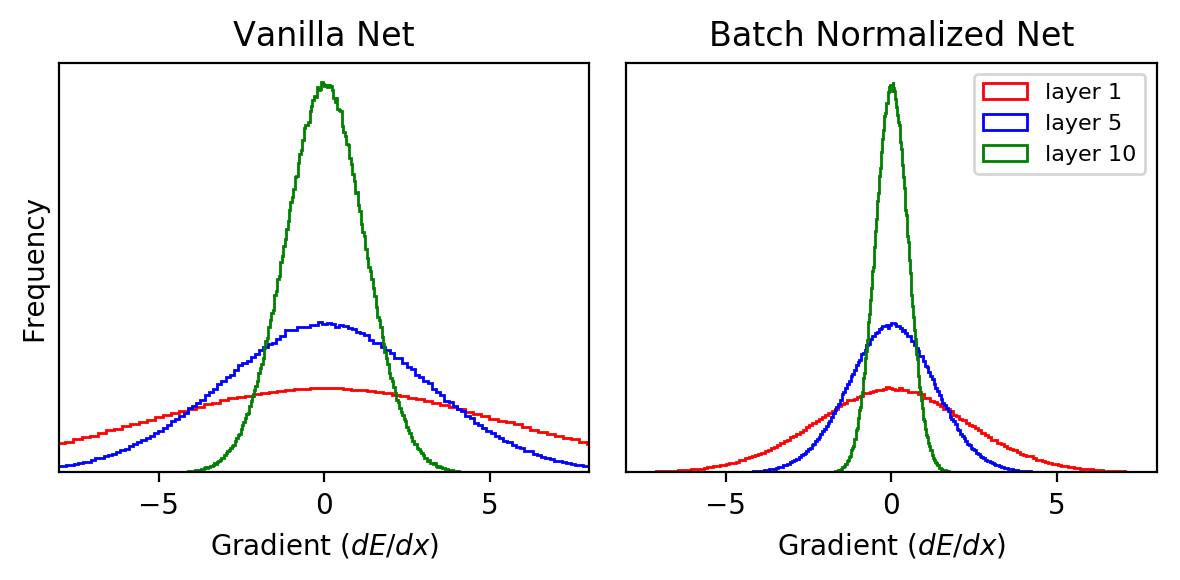

In [201]:
bins = 250
title_fontsize=12
axlabel_fontsize=10
legend_fontsize=8

plt.figure(figsize=(6,3), dpi=200)
plt.subplot(121)
plt.hist(xs_fn[0].grad.cpu().flatten(), label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(xs_fn[4].grad.cpu().flatten(), label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(xs_fn[9].grad.cpu().flatten(), label='layer 10', color='green', histtype='step', bins=bins, normed=True)

plt.xlim(-8, +8)

plt.xlabel(r'Gradient ($dE/dx$)', fontsize=axlabel_fontsize)
plt.ylabel('Frequency', fontsize=axlabel_fontsize)
plt.yticks([])
plt.title('Vanilla Net', fontsize=title_fontsize)

plt.subplot(122)
plt.hist(xs_bn[0].grad.cpu().flatten(), label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(xs_bn[4].grad.cpu().flatten(), label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(xs_bn[9].grad.cpu().flatten(), label='layer 10', color='green', histtype='step', bins=bins, normed=True)

# plt.xlim(-400,+400)
plt.xlim(-20, +20)
plt.xlim(-8, +8)

plt.legend(fontsize=legend_fontsize)
plt.yticks([])
plt.xlabel(r'Gradient ($dE/dx$)', fontsize=axlabel_fontsize)
plt.title('Batch Normalized Net', fontsize=title_fontsize)

plt.tight_layout()
# plt.savefig('../assets/bn_gradient_simulation.png')
plt.show()

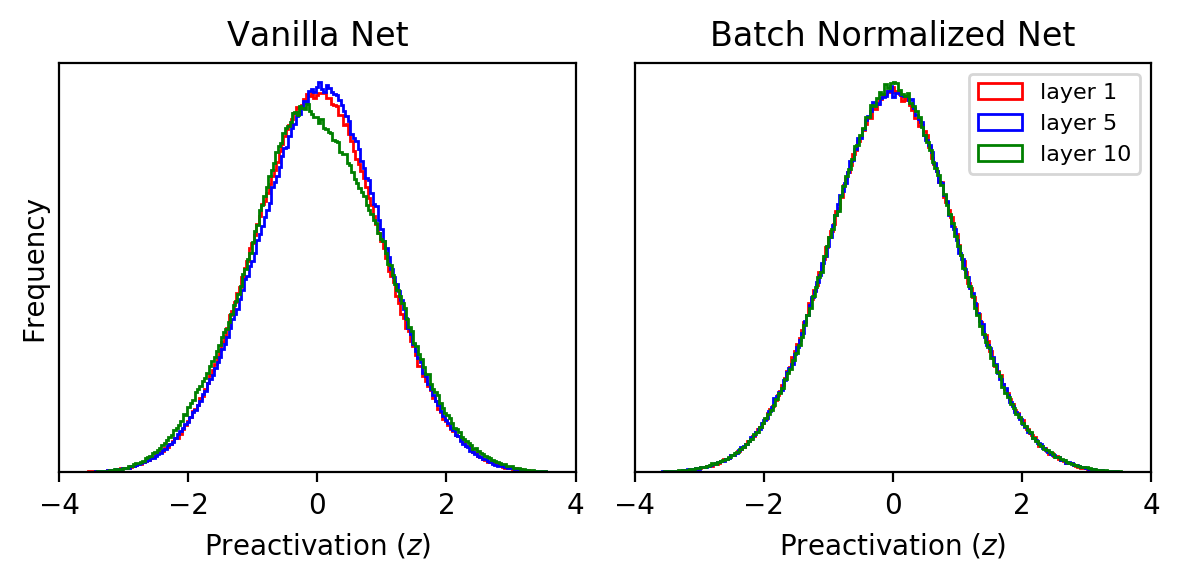

In [173]:
bins = 250
title_fontsize=12
axlabel_fontsize=10
legend_fontsize=8

plt.figure(figsize=(6,3), dpi=200)
plt.subplot(121)
plt.hist(zs_vn[0].detach().cpu().flatten(), label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(zs_vn[4].detach().cpu().flatten(), label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(zs_vn[9].detach().cpu().flatten(), label='layer 10', color='green', histtype='step', bins=bins, normed=True)

plt.xlim(-4.0,+4.0)

plt.xlabel(r'Preactivation ($z$)', fontsize=axlabel_fontsize)
plt.ylabel('Frequency', fontsize=axlabel_fontsize)
plt.yticks([])
plt.title('Vanilla Net', fontsize=title_fontsize)

plt.subplot(122)
plt.hist(zs_bn[0].detach().cpu().flatten(), label='layer 1', color='red', histtype='step', bins=bins, normed=True)
plt.hist(zs_bn[4].detach().cpu().flatten(), label='layer 5', color='blue', histtype='step', bins=bins, normed=True)
plt.hist(zs_bn[9].detach().cpu().flatten(), label='layer 10', color='green', histtype='step', bins=bins, normed=True)

plt.xlim(-4.0,+4.0)

plt.legend(fontsize=legend_fontsize)
plt.yticks([])
plt.xlabel(r'Preactivation ($z$)', fontsize=axlabel_fontsize)
plt.title('Batch Normalized Net', fontsize=title_fontsize)

plt.tight_layout()
plt.savefig('../assets/bn_preactivations.png')
plt.show()

## Grad Distributions

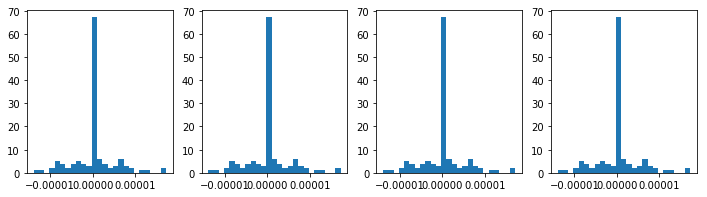

In [49]:
gzs_vn = [z.grad for x in xs_vn]
gzs_bn = [z.grad for x in xs_bn]

plt.figure(figsize=(12,3))
plt.subplot(141)
plt.hist(gzs_vn[0][:,0].cpu(), bins=25)

plt.subplot(142)
plt.hist(gzs_vn[4][:,0].cpu(), bins=25)

plt.subplot(143)
plt.hist(gzs_vn[9][:,0].cpu(), bins=25)

plt.subplot(144)
plt.hist(gzs_vn[24][:,0].cpu(), bins=25)
plt.show()
